# Optical waveguide modes

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

We describe the geometry using shapely.
In this case it's simple: we use a shapely.box for the waveguide.
For the surrounding we buffer the core and clip it to the part below the waveguide for the box.
The remaining buffer is used as the clad.
For the core we set the resolution to 30nm and let it fall of over 500nm

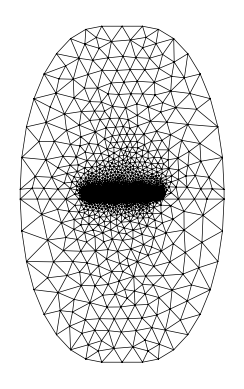

In [2]:
wg_width = 2.5
wg_thickness = 0.3
core = shapely.geometry.box(-wg_width / 2, 0, +wg_width / 2, wg_thickness)
env = shapely.affinity.scale(core.buffer(5, resolution=8), xfact=0.5)

polygons = OrderedDict(
    core=core,
    box=clip_by_rect(env, -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(env, -np.inf, 0, np.inf, np.inf),
)

resolutions = dict(core={"resolution": 0.03, "distance": 0.5})

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))
mesh.draw().show()

Let's also plot the domains

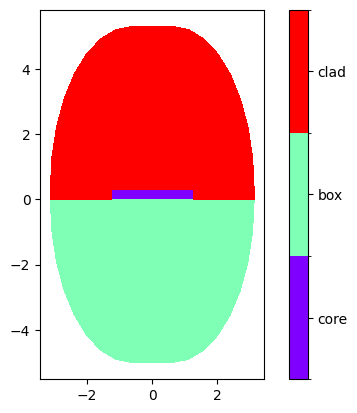

In [3]:
plot_domains(mesh)
plt.show()

On this mesh, we define the epsilon. We do this by setting domainwise the epsilon to the squared refractive index.

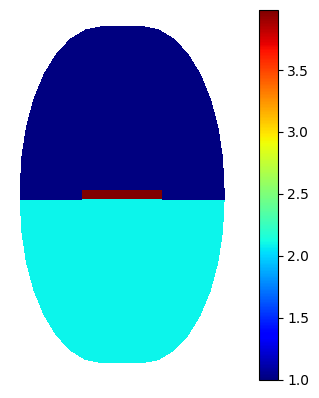

In [4]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 1.9963, "box": 1.444, "clad": 1}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

And now we call `compute_modes` to calculate the modes of the waveguide we set up.
As modes can have complex fields as soon as the epsilon gets complex, so we get a complex field for each mode.
Here we show only the real part of the mode.

Effective refractive index: 1.5996+0.0000j


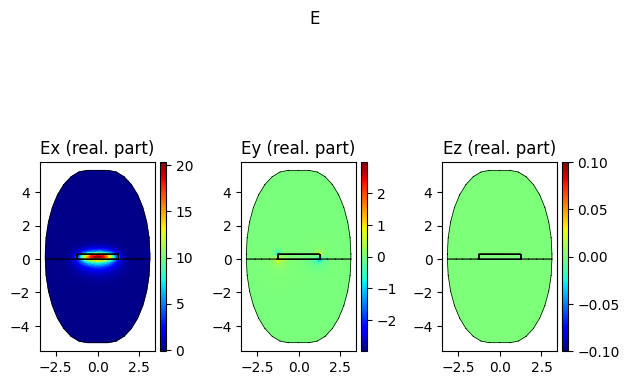

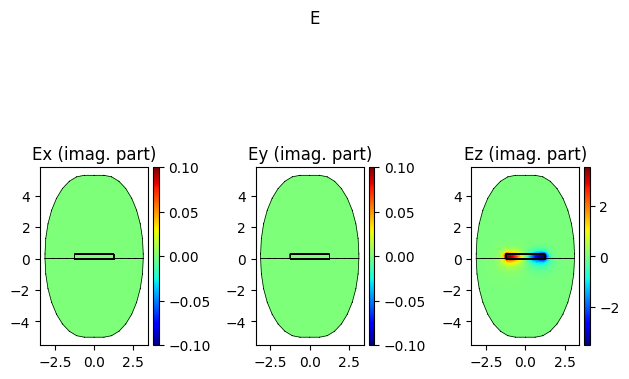

Effective refractive index: 1.5202+0.0000j


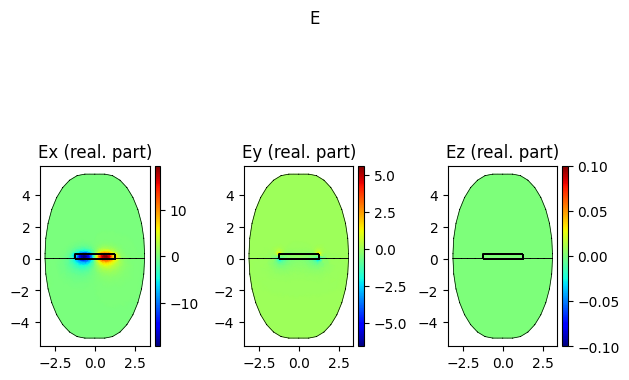

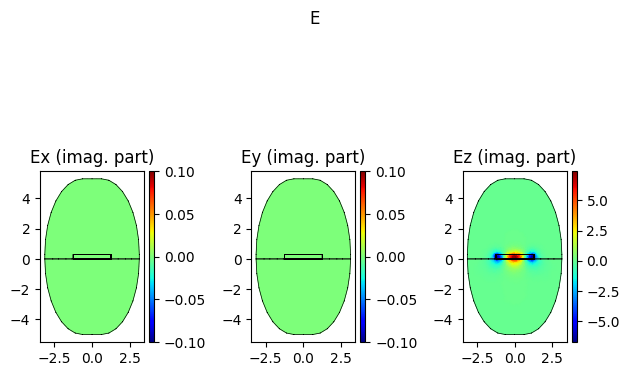

In [5]:
wavelength = 1.55

modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show("E", part="real", colorbar=True)
    mode.show("E", part="imag", colorbar=True)

The intensity can be plotted directly from the mode object
+

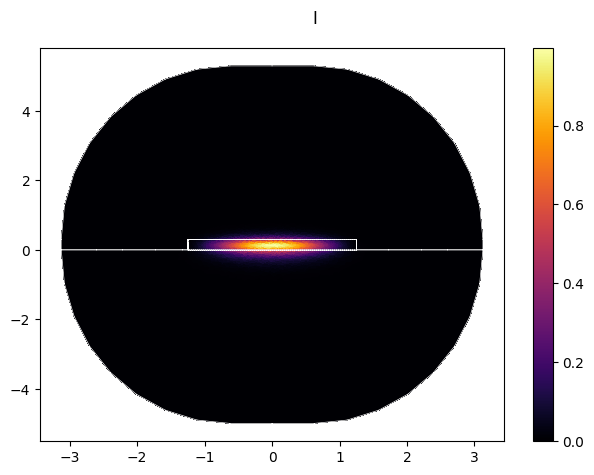

In [6]:
modes[0].show("I", colorbar=True)

-

Now, let's calculate with the modes:
What percentage of the mode is within the core for the calculated modes?

In [7]:
powers_in_waveguide = []
confinement_factors_waveguide = []

for mode in modes:
    powers_in_waveguide.append(mode.calculate_power(elements="core"))
    confinement_factors_waveguide.append(mode.calculate_confinement_factor(elements="core"))
print(powers_in_waveguide)
print(confinement_factors_waveguide)

[(0.6049092642620393+0j), (0.5754481622844267+0j)]
[(0.752034295849338+0j), (0.7441578331749029+0j)]
